In [1]:
# Initialization
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import hddm
import numpy as np
import pickle
from patsy import dmatrix
from kabuki.analyze import gelman_rubin
from kabuki.analyze import post_pred_gen
from kabuki.utils import concat_models
import pathlib

In [2]:
print (hddm.__version__)

1.0.1RC


In [3]:
data_F = hddm.load_csv('./HDDM_InconStim_6Frame.csv')

In [4]:
data_F.head(10)

,subj_idx,trial,rt,stim_frame,key_response,response,blockname,task,stim_file,HSF_emo,LSF_emo,congruence
0,114192,2,0.984893,6,e,1,BlockFvN,1,A,2,1,2
1,114192,6,0.926056,6,e,1,BlockFvN,1,B,1,2,2
2,114192,9,0.854008,6,e,1,BlockFvN,1,B,1,2,2
3,114192,11,0.881858,6,e,1,BlockFvN,1,B,1,2,2
4,114192,12,0.918875,6,e,1,BlockFvN,1,B,1,2,2
5,114192,13,0.906791,6,e,1,BlockFvN,1,B,1,2,2
6,114192,15,0.949124,6,f,0,BlockFvN,1,A,2,1,2
7,114192,16,0.839553,6,e,1,BlockFvN,1,A,2,1,2
8,114192,17,1.006603,6,f,0,BlockFvN,1,A,2,1,2
9,114192,24,0.855258,6,f,0,BlockFvN,1,A,2,1,2


In [5]:
data_F.tail(10)

,subj_idx,trial,rt,stim_frame,key_response,response,blockname,task,stim_file,HSF_emo,LSF_emo,congruence
9740,993849,330,0.601870,6,n,0,BlockF_1,2,B,1,2,2
9741,993849,331,0.681040,6,b,1,BlockF_1,2,A,2,1,2
9742,993849,332,0.599069,6,b,1,BlockF_1,2,B,1,2,2
9743,993849,334,0.551520,6,n,0,BlockF_1,2,A,2,1,2
9744,993849,336,0.538108,6,b,1,BlockF_1,2,B,1,2,2
9745,993849,339,0.776732,6,b,1,BlockF_1,2,A,2,1,2
9746,993849,341,0.503375,6,n,0,BlockF_1,2,A,2,1,2
9747,993849,343,0.515187,6,n,0,BlockF_1,2,B,1,2,2
9748,993849,344,0.614084,6,b,1,BlockF_1,2,A,2,1,2
9749,993849,349,0.615294,6,b,1,BlockF_1,2,B,1,2,2


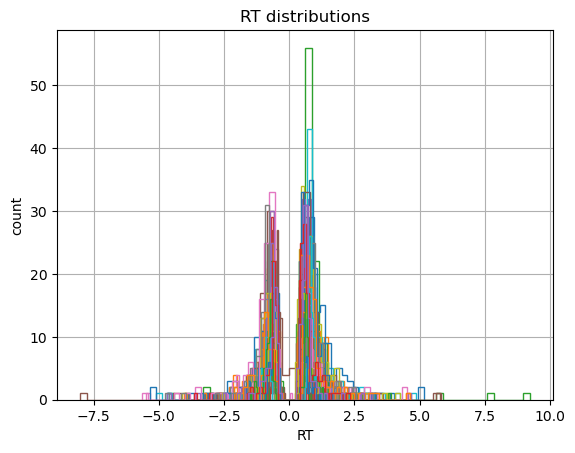

In [6]:
# Plot the RT distributions for the upper (+) and lower (-) bounds
# first flip the RT for the lower bound using flip error, i.e., the lower bound RT to make it negative
data_F = hddm.utils.flip_errors(data_F)
fig = plt.figure()
ax = fig.add_subplot(111, xlabel = 'RT', ylabel = 'count', title = 'RT distributions')
for i, subj_data in data_F.groupby('subj_idx'):
    subj_data.rt.hist(bins = 50, histtype = 'step', ax = ax)
    
plt.savefig('./testrt.pdf')

In [7]:
# Define dependencies for the drift rate (v)
dependencies = {'v': ['HSF_emo', 'task']}

# Instantiate the HDDM model with the specified dependencies
m2 = hddm.HDDM(
    data_F, 
    include=('z', 'v', 'a', 't'), 
    depends_on=dependencies, 
    p_outlier=0.05, 
    informative=False
)

# Find good starting values for the model (helps with convergence)
m2.find_starting_values()

# Sample from the posterior distribution
m2.sample(
    5000,  # Number of samples
    burn=2500,  # Burn-in period
    thin=2,  # Thinning interval
    dbname='./m2_traces.db',  # Database name to save traces
    db='pickle'  # Use pickle format for saving traces
)


No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 5001 of 5000 complete in 2152.6 sechddm sampling elpased time:  2152.879 s


In [8]:
m2.save('./m2_traces')

In [9]:
stats = m2.gen_stats()
m2.print_stats()

                        mean       std      2.5q       25q       50q       75q     97.5q    mc err
a                   1.363362  0.030802  1.298523    1.3429  1.363326  1.383597  1.424041  0.000926
a_std               0.231508  0.022654  0.191785  0.215512  0.230455  0.245805  0.277207  0.000706
a_subj.114192       1.430965  0.075849  1.295273  1.378418  1.424438  1.480326  1.594077   0.00287
a_subj.136867       1.341514  0.055469  1.228638  1.305686  1.340158  1.378497  1.451316  0.001737
a_subj.152317       1.297757  0.054185  1.198098  1.260245  1.295669  1.332374  1.415632  0.001638
a_subj.160211       1.159914  0.052938  1.057556  1.123868  1.156353  1.194464  1.270592  0.001912
a_subj.185005       1.319449  0.061207  1.204412  1.277779  1.315805    1.3618    1.4439  0.001855
a_subj.207436       1.569086  0.082189  1.401217  1.515895  1.569161  1.624744  1.734387  0.003627
a_subj.215147       1.377815  0.061132  1.265277  1.334705   1.37618  1.417229  1.504265  0.001814
a_subj.243

In [10]:
# Inspect nodes in the model to verify naming conventions
print(m2.nodes_db[m2.nodes_db.index.str.contains('v')])

                   knode_name stochastic observed   subj                node   
v(1.1)                      v       True    False  False              v(1.1)  \
v(1.2)                      v       True    False  False              v(1.2)   
v(1.3)                      v       True    False  False              v(1.3)   
v(2.1)                      v       True    False  False              v(2.1)   
v(2.2)                      v       True    False  False              v(2.2)   
...                       ...        ...      ...    ...                 ...   
v_subj(2.2).992194     v_subj       True    False   True  v_subj(2.2).992194   
v_subj(2.3).992194     v_subj       True    False   True  v_subj(2.3).992194   
v_subj(2.1).993849     v_subj       True    False   True  v_subj(2.1).993849   
v_subj(2.2).993849     v_subj       True    False   True  v_subj(2.2).993849   
v_subj(2.3).993849     v_subj       True    False   True  v_subj(2.3).993849   

                       tag             

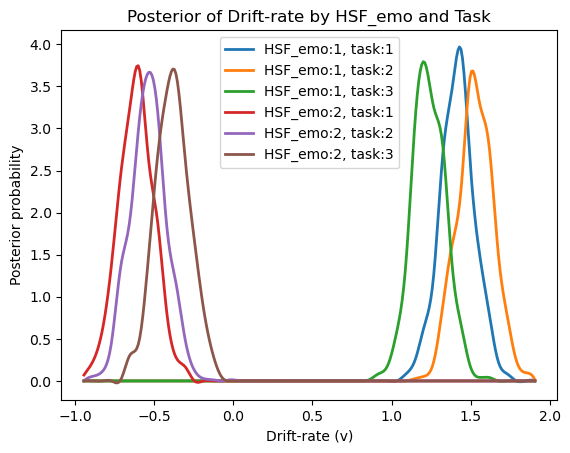

In [11]:
# Extract posterior nodes for drift rate (v) based on combinations of HSF_emo and task
v_hsf1_task1 = m2.nodes_db.node['v(1.1)']
v_hsf1_task2 = m2.nodes_db.node['v(1.2)']
v_hsf1_task3 = m2.nodes_db.node['v(1.3)']
v_hsf2_task1 = m2.nodes_db.node['v(2.1)']
v_hsf2_task2 = m2.nodes_db.node['v(2.2)']
v_hsf2_task3 = m2.nodes_db.node['v(2.3)']


# Plot the posterior distributions for all combinations
hddm.analyze.plot_posterior_nodes([
    v_hsf1_task1, v_hsf1_task2, v_hsf1_task3,
    v_hsf2_task1, v_hsf2_task2, v_hsf2_task3
])


# Add labels, title, and legend
plt.xlabel('Drift-rate (v)')
plt.ylabel('Posterior probability')
plt.title('Posterior of Drift-rate by HSF_emo and Task')
plt.legend([
    'HSF_emo:1, task:1', 'HSF_emo:1, task:2', 'HSF_emo:1, task:3',
    'HSF_emo:2, task:1', 'HSF_emo:2, task:2', 'HSF_emo:2, task:3'
])

# Save the plot
plt.savefig('./m2_drift_rate_by_factors.pdf', bbox_inches="tight")

# Show the plot
plt.show()

In [12]:
# Perform pairwise comparisons for drift rate (v) between different combinations
# Ensure you have the correct nodes already extracted (e.g., v_hsf1_task1, v_hsf1_task2, etc.)

print("P(v(1.1) > v(1.2)) = ", 
      (v_hsf1_task1.trace() > v_hsf1_task2.trace()).mean())
print("P(v(1.1) > v(1.3)) = ", 
      (v_hsf1_task1.trace() > v_hsf1_task3.trace()).mean())
print("P(v(1.2) > v(1.3)) = ", 
      (v_hsf1_task2.trace() > v_hsf1_task3.trace()).mean())

print("P(v(2.1) > v(2.2)) = ", 
      (v_hsf2_task1.trace() > v_hsf2_task2.trace()).mean())
print("P(v(2.1) > v(2.3)) = ", 
      (v_hsf2_task1.trace() > v_hsf2_task3.trace()).mean())
print("P(v(2.2) > v(2.3)) = ", 
      (v_hsf2_task2.trace() > v_hsf2_task3.trace()).mean())

print("P(v(1.1) > v(2.1)) = ", 
      (v_hsf1_task1.trace() > v_hsf2_task1.trace()).mean())
print("P(v(1.2) > v(2.2)) = ", 
      (v_hsf1_task2.trace() > v_hsf2_task2.trace()).mean())
print("P(v(1.3) > v(2.3)) = ", 
      (v_hsf1_task3.trace() > v_hsf2_task3.trace()).mean())

P(v(1.1) > v(1.2)) =  0.2296
P(v(1.1) > v(1.3)) =  0.872
P(v(1.2) > v(1.3)) =  0.9688
P(v(2.1) > v(2.2)) =  0.3136
P(v(2.1) > v(2.3)) =  0.084
P(v(2.2) > v(2.3)) =  0.1576
P(v(1.1) > v(2.1)) =  1.0
P(v(1.2) > v(2.2)) =  1.0
P(v(1.3) > v(2.3)) =  1.0
